# Navground-Gymnasium integration 

This notebook showcases the integration between navground and gymnasium.

For a started, let us define the following scenario

In [1]:
>>> import gymnasium as gym
>>> import navground_learning.env
>>> from navground import sim

# >>> scenario = sim.load_scenario(...)
>>> env = gym.make("navground", scenario=scenario)

NameError: name 'scenario' is not defined

In [ ]:
gym.Space

In [2]:
from navground import sim

scenario = sim.load_scenario("""
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
    state_estimation:
      type: Bounded
      range: 5.0
""")

where 20 agents moves like this

In [1]:
import numpy as np

sensor = sim.load_state_estimation("""
type: Discs
number: 5
range: 5.0
max_speed: 0.12
max_radius: 0.1
""")

bounds = (np.array((-2.5, -2.5)), np.array((2.5, 2.5)))

and create a `GymAgentConfig` to replicate the first agent in the scenario, and configure it's observation and action spaces

In [2]:
from navground_learning.utils import GymAgentConfig

config = GymAgentConfig().configure(scenario=scenario, sensor=sensor, index=0)
config

GymAgentConfig(flat=False, stack=1, include_target_distance=True, max_target_distance=5.0, include_target_direction=True, include_velocity=False, max_speed=0.12, max_angular_speed=2.553191489361702, include_radius=False, max_radius=inf, fix_orientation=False, dof=2)

The action space is composed of linear and angular speeds (normalized by their maximal values)

In [3]:
config.action_space, config.max_speed, config.max_angular_speed

(Box(-1.0, 1.0, (2,), float64), 0.12, 2.553191489361702)

The observation space is composed of the agent own state (`ego_...`) and the reading from the sensor, in this case `position`, `radius` and `velocity` of the 5 nearest neighbors

In [4]:
config.observation_space

Dict('position': Box(-5.0, 5.0, (5, 2), float64), 'radius': Box(0.0, 0.1, (5,), float64), 'velocity': Box(-0.12, 0.12, (5, 2), float64), 'ego_target_direction': Box(-1.0, 1.0, (2,), float64), 'ego_target_distance': Box(0.0, 5.0, (1,), float64))

coherently with the sensor's description

In [5]:
sensor.description

{'position': BufferDescription(shape=(5, 2), type=dtype('float64'), low=-5.0, high=5.0, categorical=False),
 'radius': BufferDescription(shape=(5,), type=dtype('float64'), low=0.0, high=0.1, categorical=False),
 'velocity': BufferDescription(shape=(5, 2), type=dtype('float64'), low=-0.12, high=0.12, categorical=False)}

We define a gymnasium enviroment

In [6]:
import navground_learning.env
import gymnasium as gym
import numpy as np

In [7]:
env = gym.make('navground',
               scenario=scenario,
               sensor=sensor,
               config=config,
               time_step=0.1,
               max_episode_steps=600)

It shares the same observation and action spaces as `gym_agent` 

In [8]:
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

Observation space: Dict('position': Box(-5.0, 5.0, (5, 2), float64), 'radius': Box(0.0, 0.1, (5,), float64), 'velocity': Box(-0.12, 0.12, (5, 2), float64), 'ego_target_direction': Box(-1.0, 1.0, (2,), float64), 'ego_target_distance': Box(0.0, 5.0, (1,), float64))
Action space: Box(-1.0, 1.0, (2,), float64)


The `info` returned by `reset` and `step` contains the action computed by the navground behavior, in this case `HL`:

In [9]:
observation, info = env.reset()
print(f"Observation: {observation}")
print(f"Info {info}")

Observation: {'position': array([[-0.43304107,  0.89501247],
       [-0.82809066,  0.82899893],
       [-0.34175199,  0.50351496],
       [-1.20762961,  0.70128138],
       [-1.49140224,  1.02187555]]), 'radius': array([0.1, 0.1, 0.1, 0.1, 0.1]), 'velocity': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'ego_target_direction': array([1.00000000e+00, 1.06775709e-17]), 'ego_target_distance': array([2.1121034])}
Info {'navground_action': array([0.32967995, 0.        ])}


which we can use to define a policy that simply make the agent actuate the action that it already computed. The default rewards is -1 if there is a collision else `efficacy * time_step`.

Let's collect the reward from the navground policy.

In [10]:
rewards = []
for n in range(1000):
    action = info['navground_action']
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward 0.791


and compare it (just for fun) with the reward from a random policy, which we expect to be almost zero

In [11]:
observation, info = env.reset()
rewards = []
for n in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward 0.059


Normally, we would use a policy to generate to action. For instance, a random policy, like

In [12]:
from imitation.policies.base import RandomPolicy

policy = RandomPolicy(config.observation_space, config.action_space)

Policies output a tuple `(action, state)`. Therefore the new loop is

In [13]:
observation, info = env.reset()
rewards = []
for n in range(1000):
    action, state = policy.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward 0.022


## Rendering

Gym enviroments have API to render the state of the simulation. `NavgroundEnv` supports rendering in real-time (with `render_mode="human"`) or offline (with `render_mode="rgb_array"`).

We can even render online inside a jupyter notebook.

In [15]:
import nest_asyncio
from navground.sim.ui import notebook_view
from navground.sim.ui.to_html import open_html
nest_asyncio.apply()

In [16]:
open_html(640, port=8002)

In [17]:
notebook_view(width=300, port=8002)

In [18]:
rt_env = gym.make('navground',
                  scenario=scenario,
                  sensor=sensor,
                  time_step=0.1,
                  max_duration=60.0,
                  config=config,
                  render_mode="human",
                  realtime_factor=10.0,
                  bounds=bounds)

In [19]:
observation, info = rt_env.reset()
for n in range(750):
    action = info['navground_action']
    observation, reward, terminated, truncated, info = rt_env.step(action)
    if terminated or truncated:
        observation, info = rt_env.reset()
rt_env.close()

To render offline, we call `render()`

In [20]:
from PIL import Image
from IPython.display import display

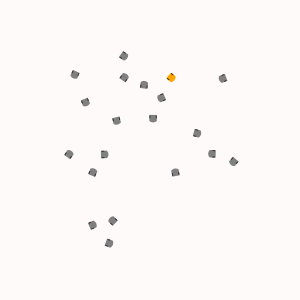

In [21]:
env = gym.make('navground',
                scenario=scenario,
                sensor=sensor,
                time_step=0.1,
                config=config,
                render_mode="rgb_array",
                render_kwargs = {'width': 300},
                bounds=bounds,
                max_episode_steps=600)
env.reset()
image = Image.fromarray(env.render())
# image.show()
image = image.resize((image.width, image.height))
display(image)

We can also render a video

In [22]:
from gymnasium.wrappers import RecordVideo

video_env = RecordVideo(
    env, video_folder=".", name_prefix="gym",
    episode_trigger=lambda x: True,
    disable_logger=True)

# 10 x
video_env.metadata['render_fps'] = 100

obs, info = video_env.reset()
done = False
while not done:
    action = env.action_space.sample()  # replace with actual agent
    obs, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated
video_env.close()

/Users/jerome.guzzi/Dev/venv/ros/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jerome.guzzi/Dev/ROS/ros2_ws/src/navground_learning/notebooks folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [23]:
from IPython.display import Video

Video("gym-episode-0.mp4", width=300)

## Vectorized enviroments

`NavgroundEnv` supports [vectorizing](https://gymnasium.farama.org/api/vector/) the enviroment. 



In [24]:
venv = gym.vector.make("navground_learning.env:navground", num_envs=4,
    scenario=scenario,
    sensor=sensor,
    config=config,
    time_step=0.1,
    max_episode_steps=600,
    render_mode="rgb_array",
    bounds=bounds)

/Users/jerome.guzzi/Dev/venv/ros/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


In [29]:
venv.num_envs

4

Gymansium vectorized environements exposes the same API as normal enviroments. 
As expected, observation and action spaces are vectorized (i.e., with an additional axis of size `num_envs`)

In [25]:
print(f'Vectorized observation space: {venv.observation_space}')
print(f'Vectorized action space: {venv.action_space}')

Vectorized observation space: Dict('position': Box(-5.0, 5.0, (4, 5, 2), float64), 'radius': Box(0.0, 0.1, (4, 5), float64), 'velocity': Box(-0.12, 0.12, (4, 5, 2), float64), 'ego_target_direction': Box(-1.0, 1.0, (4, 2), float64), 'ego_target_distance': Box(0.0, 5.0, (4, 1), float64))
Vectorized action space: Box(-1.0, 1.0, (4, 2), float64)


In [26]:
observation, info = venv.reset(seed=1)

Once seeded, the enviroments contains different worlds

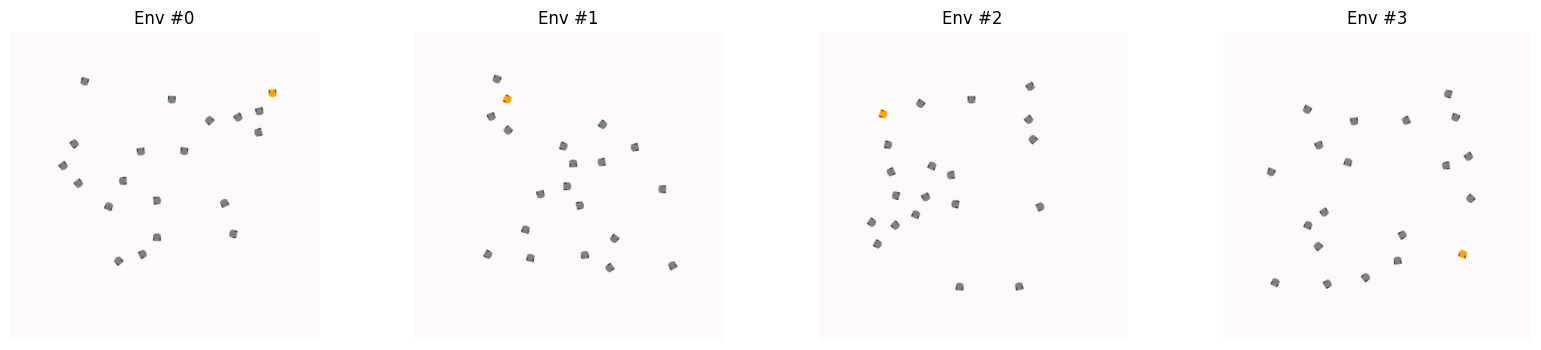

In [27]:
from matplotlib import pyplot as plt
images = venv.call("render")
fig, axs = plt.subplots(ncols=len(images), figsize=(20, 4))

for i, (ax, im) in enumerate(zip(axs, images)):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f"Env #{i}")

and can be simulated with the same loop, where we don't need to manually reset individual envs, as the vectorized env autoreset them.

In [28]:
all_rewards = []
for n in range(1000):
    # actions = info['navground_action']
    actions = venv.action_space.sample()
    observations, rewards, terminated, truncated, info = venv.step(actions)
    all_rewards.append(rewards)

all_rewards = np.array(all_rewards)
print(f'mean reward {np.mean(all_rewards, axis=0)}')

mean reward [ 0.06433477 -0.06541249  0.01504732  0.02748192]


There are other types of vectorized enviroments that exposes a slightly different API.
For instance, the vectorized enviroments of 
[Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html)
follow an older version of the Gym API, which has several [differences](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api) with respect to basics enviroments.

In [29]:
from stable_baselines3.common.env_util import make_vec_env

venv = make_vec_env(
    "navground", n_envs=4, seed=1,
     env_kwargs={
         'scenario': scenario,
         'sensor': sensor,
         'time_step': 0.1,
         'config': config,
         'render_mode': "rgb_array",
         'render_kwargs': {'width': 300},
         'bounds': bounds
     })

# use 
# venv = make_vec_env(lambda: gym.make(env.spec), n_envs=4)
# to vectorized an already defined env

In this case, actions and observations are *not* vectorized

In [30]:
print(f'Observation space: {venv.observation_space}')
print(f'Action space: {venv.action_space}')

Observation space: Dict('position': Box(-5.0, 5.0, (5, 2), float64), 'radius': Box(0.0, 0.1, (5,), float64), 'velocity': Box(-0.12, 0.12, (5, 2), float64), 'ego_target_direction': Box(-1.0, 1.0, (2,), float64), 'ego_target_distance': Box(0.0, 5.0, (1,), float64))
Action space: Box(-1.0, 1.0, (2,), float64)


and we need to use a slightly different API

In [31]:
observation = venv.reset()
info = venv.reset_infos

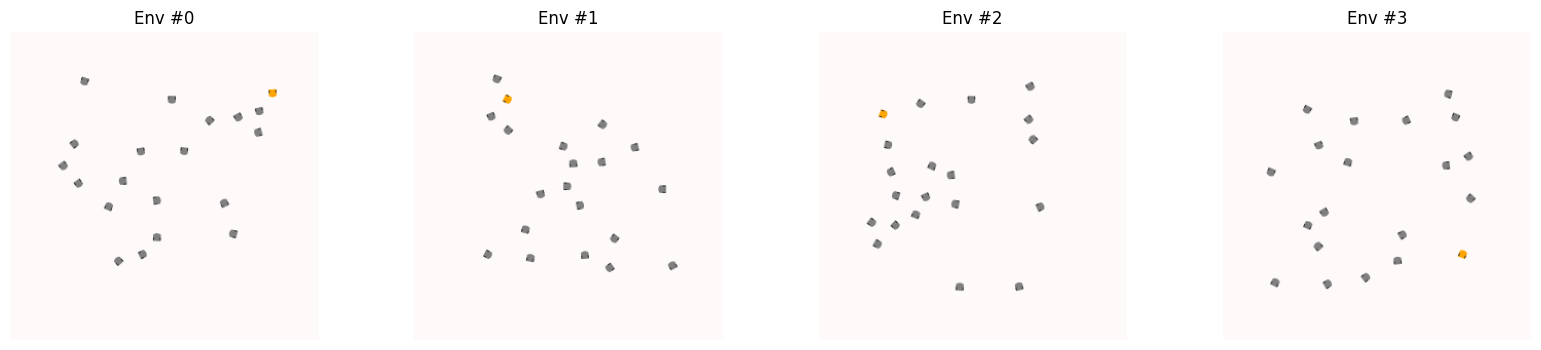

In [32]:
from matplotlib import pyplot as plt
images = venv.get_images()
fig, axs = plt.subplots(ncols=len(images), figsize=(20, 4))

for i, (ax, im) in enumerate(zip(axs, images)):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f"Env #{i}")

to get run the same cycle

In [33]:
all_rewards = []
for n in range(1000):
    # actions = [i['navground_action'] for i in info]
    actions = [venv.action_space.sample() for _ in range(venv.num_envs)]
    observations, rewards, done, info = venv.step(actions)
    all_rewards.append(rewards)

all_rewards = np.array(all_rewards)
print(f'mean reward {np.mean(all_rewards, axis=0)}')

mean reward [ 0.03149461 -0.00727142 -0.00609433  0.01462481]


## Using a policy in Navground

We have see how to use navground agents in gym.
What about the opposite?

`PolicyBehavior` wrap the policy as a navground `core.Behavior` which can be assigned to an agent.

In [17]:
from navground_learning.behaviors.policy import PolicyBehavior

world = sim.World()
scenario.init_world(world)
agent = world.agents[0]
agent.behavior = PolicyBehavior.clone(agent.behavior, policy=policy, config=config)
agent.state_estimation = sensor
agent.color = 'red'

In [18]:
print(sim.dump(agent.behavior))

type: Policy
fix_orientation: false
flat: false
policy_path: ""
stack: 1
optimal_speed: 0.12
optimal_angular_speed: 2.5531914893617018
rotation_tau: 0.5
safety_margin: 0.10000000000000001
horizon: 5
radius: 0.10000000000000001
heading: velocity
kinematics:
  type: 2WDiff
  wheel_axis: 0.094
  max_speed: 0.12
  max_angular_speed: 2.5531914893617018
social_margin:
  modulation:
    type: constant
  default: 0


We can now use any tool available in naground to run/display/record the simulation.

For instance to display a video

In [35]:
from navground.sim.ui.video import display_video

display_video(world, time_step=0.1, duration=120.0, factor=10.0,
              bounds=bounds, display_width=400)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


or record data

In [36]:
from navground_learning.env import social_reward

class RewardProbe(sim.Probe):

    def __init__(self):
        super().__init__()
        self.type = np.float64
        self.reward = social_reward(alpha=0.0, beta=1.0)

    def update(self, world: sim.World) -> None:
        self.record_step()
        for agent in world.agents:
            r = self.reward(agent, world, 0.0)
            self.push(r)

    def shape(self):
        return (self.steps, self.size // self.steps if self.steps else 0)


In [37]:
world = sim.World()
scenario.init_world(world)
agent = world.agents[0]
agent.behavior = PolicyBehavior(policy=policy, config=config)
agent.state_estimation = sensor

run = sim.ExperimentalRun(world, time_step=0.1, steps=1200, record_config=sim.RecordConfig.all(True))
reward_probe = RewardProbe()
run.add_probe("reward", reward_probe)

run.run()

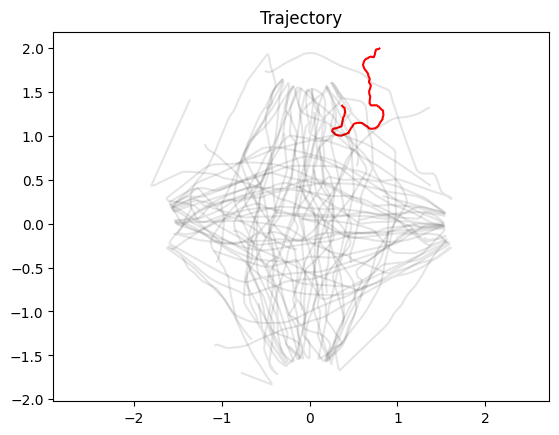

In [38]:
from matplotlib import pyplot as plt

xs, ys = run.poses[:, 0, :2].T
plt.plot(xs, ys, 'r')
for i in range(1, 20):
    xs, ys = run.poses[:, i, :2].T
    plt.plot(xs, ys, 'k', alpha=0.1)
plt.axis('equal');
plt.title('Trajectory');

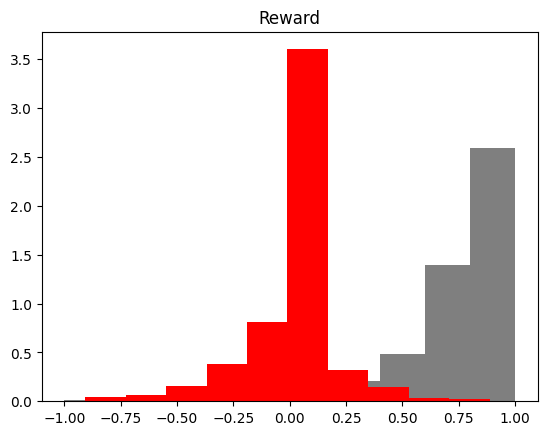

In [39]:
plt.hist(reward_probe.data[:, 1:].flatten(), density=True, color='black', alpha=0.5)
plt.hist(reward_probe.data[:, 0], density=True, color='red');
plt.title('Reward');